# Predicting S&P 500 Returns Using Fed Probabilities

This notebook trains XGBoost models to predict next-day S&P 500 returns based on Fed event probabilities.


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


In [33]:
# Load the merged dataset
df = pd.read_csv("../data/sp500_fed_ml_ready_with_targets.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
print(f"Total rows: {len(df)}")


Dataset shape: (205, 110)
Date range: 2024-12-30 00:00:00 to 2025-10-23 00:00:00
Total rows: 205


In [34]:
# IMPORTANT: Fed probabilities are available at 00:00 (midnight)
# Market opens at 14:30 (2:30 PM) on the same day
# So we should predict INTRADAY return (Open to Close) on the SAME day
# Strategy: Use Fed probabilities from day T (00:00) to predict return from day T's Open to Close

print("=== TARGET VARIABLE: INTRADAY RETURN (Open to Close) ===")
print("Timing:")
print("  - Fed probabilities available: 00:00 (midnight) on day T")
print("  - Market opens: 14:30 (2:30 PM) on day T")
print("  - Market closes: 21:00 (9:00 PM) on day T")
print("  - Strategy: Buy at open, sell at close on same day\n")

# Calculate intraday return: (Close - Open) / Open
df['intraday_return'] = (df['Close'] - df['Open']) / df['Open']

# Alternative: Use Open_Close_Range which is already calculated
# But let's use our calculated one for clarity
if 'Open_Close_Range' in df.columns:
    print(f"Open_Close_Range stats: mean={df['Open_Close_Range'].mean():.6f}, std={df['Open_Close_Range'].std():.6f}")
    print(f"Calculated intraday_return stats: mean={df['intraday_return'].mean():.6f}, std={df['intraday_return'].std():.6f}")
    # Use the calculated one
    df['target_intraday_return'] = df['intraday_return']
else:
    df['target_intraday_return'] = df['intraday_return']

print(f"\nIntraday return stats:")
print(f"  Mean: {df['target_intraday_return'].mean():.6f}")
print(f"  Std: {df['target_intraday_return'].std():.6f}")
print(f"  Min: {df['target_intraday_return'].min():.6f}")
print(f"  Max: {df['target_intraday_return'].max():.6f}")

# Identify feature columns
fed_feature_cols = [col for col in df.columns if col.startswith('Fed_') or 'How_many' in col or 'Jerome' in col or 'Who_will' in col]
sp500_feature_cols = ['Daily_Return', 'Log_Return', 'High_Low_Range', 'Volume_Ratio', 
                      'Price_MA_20', 'Price_MA_50', 'Volatility_20']
# Note: We exclude 'Open_Close_Range' from features since it's our target

# Combine all features
feature_cols = fed_feature_cols + sp500_feature_cols

# Remove any columns that don't exist
feature_cols = [col for col in feature_cols if col in df.columns]

print(f"\nTotal features: {len(feature_cols)}")
print(f"  - Fed features: {len(fed_feature_cols)}")
print(f"  - S&P 500 features: {len(sp500_feature_cols)}")

# Prepare features and target
X = df[feature_cols].copy()
y = df['target_intraday_return'].copy()  # Changed to intraday return

# Remove rows with NaN targets
valid_idx = ~y.isna()
X = X[valid_idx].copy()
y = y[valid_idx].copy()
dates = df.loc[valid_idx, 'Date'].copy()

# Fill any remaining NaN with 0
X = X.fillna(0)

print(f"\nAfter removing NaN targets:")
print(f"  X shape: {X.shape}")
print(f"  y shape: {y.shape}")
print(f"  Target stats: mean={y.mean():.4f}, std={y.std():.4f}")
print(f"\n✓ Target: Intraday return (Open to Close) on same day")
print(f"✓ Strategy: Use Fed probabilities from 00:00 to predict same-day open-to-close return")


=== TARGET VARIABLE: INTRADAY RETURN (Open to Close) ===
Timing:
  - Fed probabilities available: 00:00 (midnight) on day T
  - Market opens: 14:30 (2:30 PM) on day T
  - Market closes: 21:00 (9:00 PM) on day T
  - Strategy: Buy at open, sell at close on same day

Open_Close_Range stats: mean=0.006490, std=0.008448
Calculated intraday_return stats: mean=0.000455, std=0.010961

Intraday return stats:
  Mean: 0.000455
  Std: 0.010961
  Min: -0.041205
  Max: 0.099012

Total features: 95
  - Fed features: 88
  - S&P 500 features: 7

After removing NaN targets:
  X shape: (205, 95)
  y shape: (205,)
  Target stats: mean=0.0005, std=0.0110

✓ Target: Intraday return (Open to Close) on same day
✓ Strategy: Use Fed probabilities from 00:00 to predict same-day open-to-close return


## Approach 1: 80/20 Train-Test Split


In [35]:
# 80/20 split (shuffle=False to maintain temporal order)
X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(
    X, y, dates, test_size=0.2, shuffle=False, random_state=42
)

print(f"Training set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"  Date range: {dates_train.min()} to {dates_train.max()}")
print(f"\nTest set: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")
print(f"  Date range: {dates_test.min()} to {dates_test.max()}")


Training set: 164 samples (80.0%)
  Date range: 2024-12-30 00:00:00 to 2025-08-26 00:00:00

Test set: 41 samples (20.0%)
  Date range: 2025-08-27 00:00:00 to 2025-10-23 00:00:00


In [36]:
# DIAGNOSIS: With only ~205 rows and ~100+ features, we have severe overfitting risk
# The target is: target_intraday_return (same day's Open to Close return)
print(f"\n⚠️  DATA SIZE WARNING:")
print(f"  Training samples: {len(X_train)}")
print(f"  Test samples: {len(X_test)}")
print(f"  Features: {len(feature_cols)}")
print(f"  Ratio: {len(X_train)/len(feature_cols):.2f} samples per feature")
print(f"  Target: target_intraday_return (same day Open to Close return)")
print(f"  Strategy: Buy at open, sell at close on same day")
print(f"\n  Recommendation: Need at least 10-20 samples per feature for stable models")
print(f"  Current: {len(X_train)/len(feature_cols):.2f} samples per feature")

# Feature selection to reduce overfitting
print("\n=== FEATURE SELECTION ===")
from sklearn.feature_selection import SelectKBest, f_regression

# Select top features based on correlation with target
selector = SelectKBest(f_regression, k=min(20, len(feature_cols)))  # Top 20 features
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

selected_features = [feature_cols[i] for i in selector.get_support(indices=True)]
print(f"Selected {len(selected_features)} most important features")
print(f"Top 10: {selected_features[:10]}")

# Train XGBoost model with REGULARIZATION (to prevent overfitting)
print("\nTraining XGBoost model with regularization...")

model_80_20 = xgb.XGBRegressor(
    n_estimators=100,  # Reduced from 200
    max_depth=3,       # Reduced from 6 (shallower trees)
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,      # L1 regularization
    reg_lambda=1.0,     # L2 regularization
    min_child_weight=3, # Minimum samples per leaf
    random_state=42,
    n_jobs=-1
)

# Train on selected features
model_80_20.fit(X_train_selected, y_train)

# Predictions (store with specific names to avoid conflicts)
y_train_pred_80_20 = model_80_20.predict(X_train_selected)
y_test_pred_80_20 = model_80_20.predict(X_test_selected)

# Evaluate
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_80_20))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_80_20))
train_mae = mean_absolute_error(y_train, y_train_pred_80_20)
test_mae = mean_absolute_error(y_test, y_test_pred_80_20)
train_r2 = r2_score(y_train, y_train_pred_80_20)
test_r2 = r2_score(y_test, y_test_pred_80_20)

print("\n=== Model Performance (80/20 Split with Feature Selection) ===")
print(f"Training RMSE: {train_rmse:.6f}")
print(f"Test RMSE: {test_rmse:.6f}")
print(f"Training MAE: {train_mae:.6f}")
print(f"Test MAE: {test_mae:.6f}")
print(f"Training R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")

if test_r2 < 0:
    print("\n⚠️  WARNING: Negative R² means model performs worse than predicting the mean!")
    print("   This indicates severe overfitting or insufficient data.")



⚠️  DATA SIZE WARNING:
  Training samples: 164
  Test samples: 41
  Features: 95
  Ratio: 1.73 samples per feature
  Target: target_intraday_return (same day Open to Close return)
  Strategy: Buy at open, sell at close on same day

  Recommendation: Need at least 10-20 samples per feature for stable models
  Current: 1.73 samples per feature

=== FEATURE SELECTION ===
Selected 20 most important features
Top 10: ['Fed_emergency_rate_cut_in_2025_Price', 'How_many_Fed_rate_cuts_in_2025_1_25_bps', 'How_many_Fed_rate_cuts_in_2025_2_50_bps', 'How_many_Fed_rate_cuts_in_2025_5_125_bps', 'How_many_Fed_rate_cuts_in_2025_6_150_bps', 'How_many_Fed_rate_cuts_in_2025_7_175_bps', 'Who_will_Trump_announce_as_next_Fed_Chair_in_2025_Arthur_Laffer', 'Who_will_Trump_announce_as_next_Fed_Chair_in_2025_Chamath_Palihapitiya', 'Who_will_Trump_announce_as_next_Fed_Chair_in_2025_Kevin_Warsh', 'Who_will_Trump_announce_as_next_Fed_Chair_in_2025_Larry_Kudlow']

Training XGBoost model with regularization...

=== M


=== Most Important Features (Selected) ===
                                              feature  importance
13                                       Daily_Return    0.252654
14                                         Log_Return    0.232540
3            How_many_Fed_rate_cuts_in_2025_5_125_bps    0.073991
15                                     High_Low_Range    0.071932
4            How_many_Fed_rate_cuts_in_2025_6_150_bps    0.061483
2             How_many_Fed_rate_cuts_in_2025_2_50_bps    0.053934
5            How_many_Fed_rate_cuts_in_2025_7_175_bps    0.039483
17                                        Price_MA_20    0.031637
19                                      Volatility_20    0.028761
0                Fed_emergency_rate_cut_in_2025_Price    0.026270
18                                        Price_MA_50    0.023819
7   Who_will_Trump_announce_as_next_Fed_Chair_in_2...    0.022804
16                                       Volume_Ratio    0.022153
12  Who_will_Trump_announce_as_n

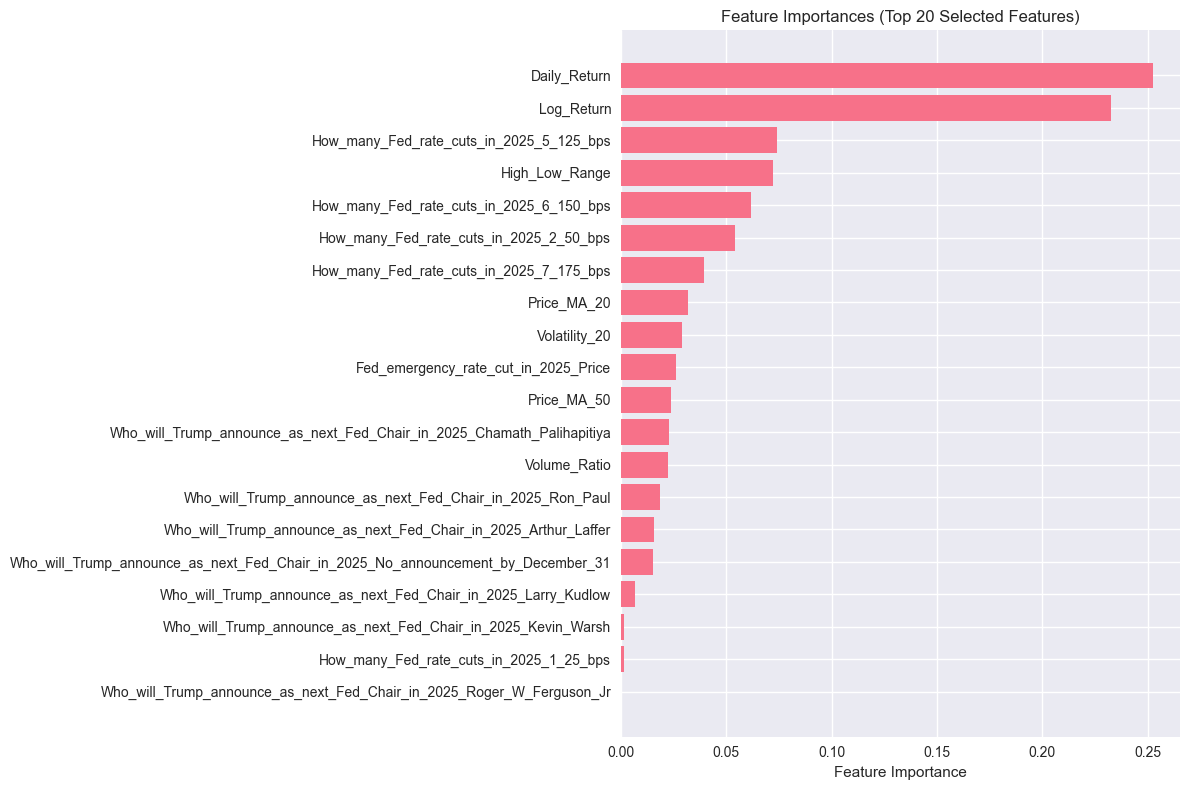

In [37]:
# Feature importance (for selected features)
feature_importance = pd.DataFrame({
    'feature': selected_features,
    'importance': model_80_20.feature_importances_
}).sort_values('importance', ascending=False)

print("\n=== Most Important Features (Selected) ===")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(12, 8))
plt.barh(range(len(feature_importance)), feature_importance['importance'])
plt.yticks(range(len(feature_importance)), feature_importance['feature'])
plt.xlabel('Feature Importance')
plt.title(f'Feature Importances (Top {len(selected_features)} Selected Features)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


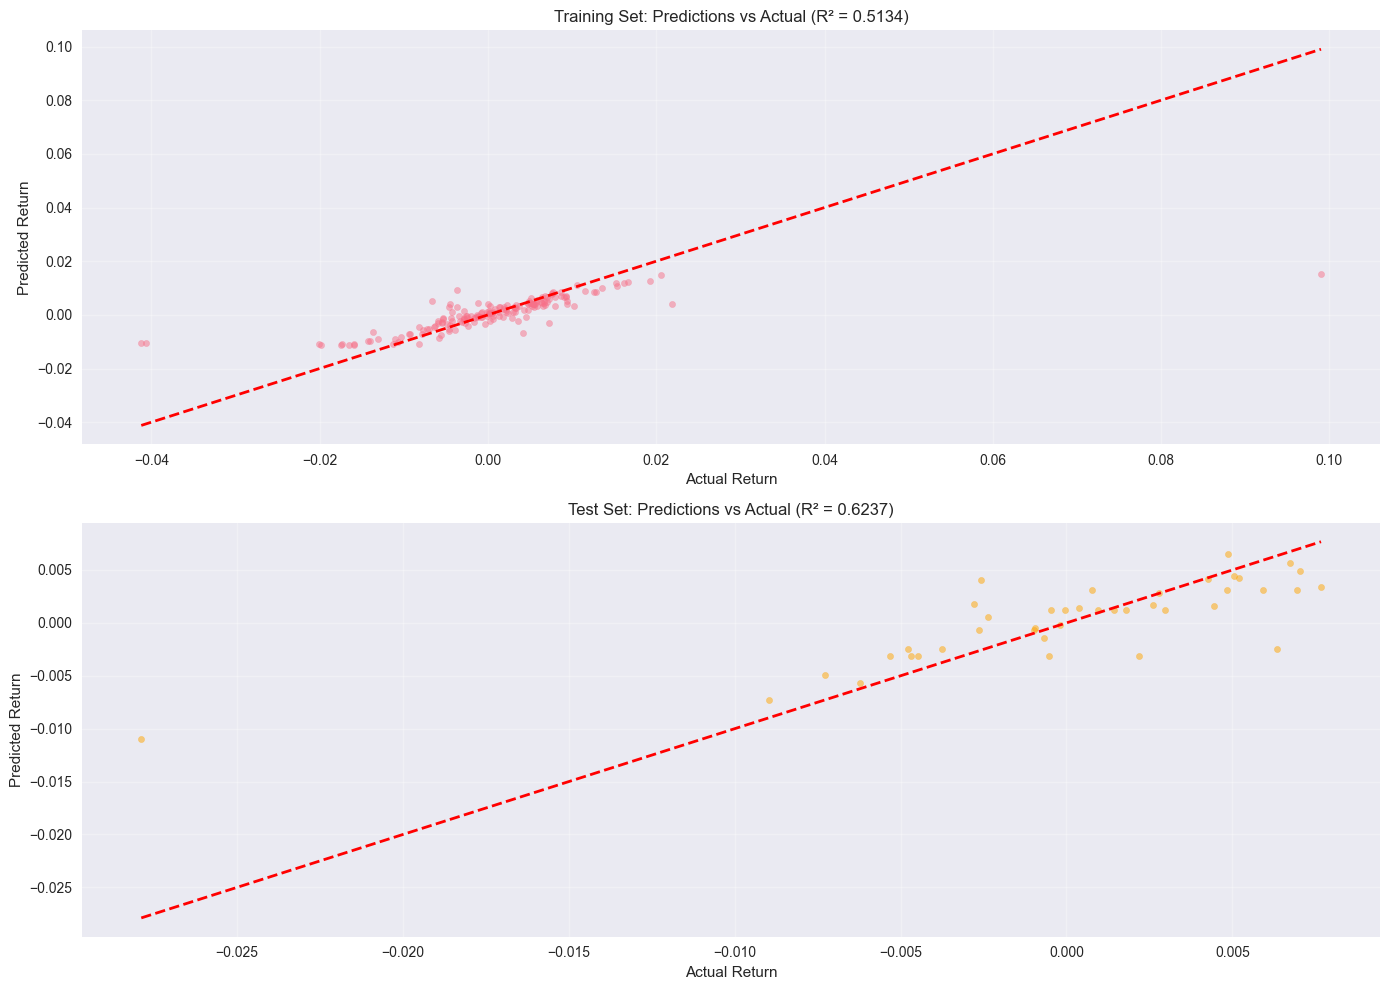

In [38]:
# Plot predictions vs actual
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Training set
axes[0].scatter(y_train, y_train_pred_80_20, alpha=0.5, s=20)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Return')
axes[0].set_ylabel('Predicted Return')
axes[0].set_title(f'Training Set: Predictions vs Actual (R² = {train_r2:.4f})')
axes[0].grid(True, alpha=0.3)

# Test set
axes[1].scatter(y_test, y_test_pred_80_20, alpha=0.5, s=20, color='orange')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Return')
axes[1].set_ylabel('Predicted Return')
axes[1].set_title(f'Test Set: Predictions vs Actual (R² = {test_r2:.4f})')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


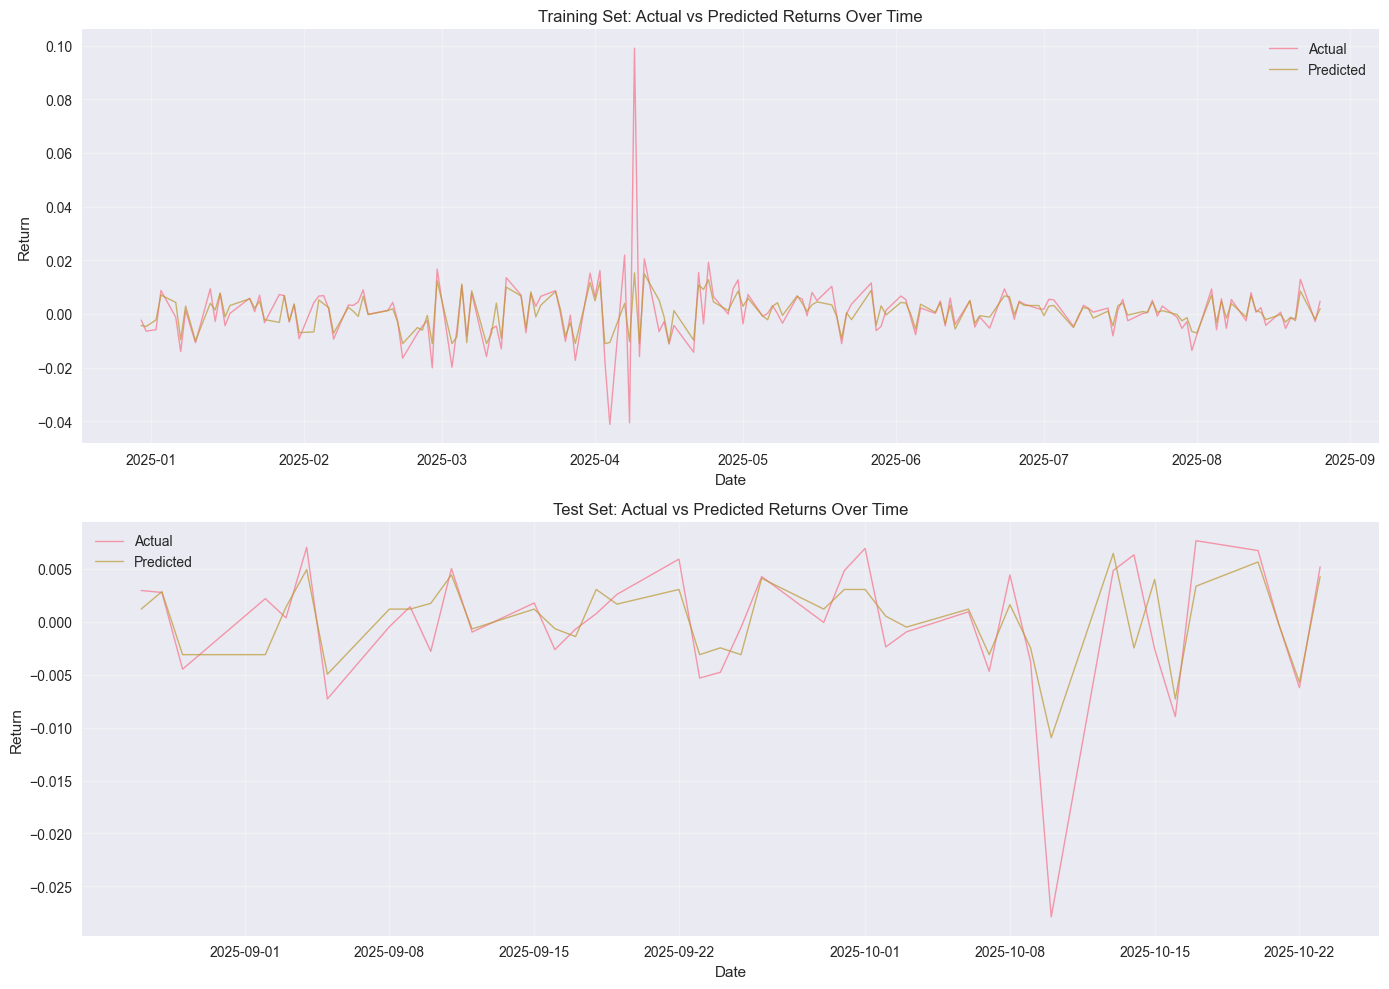

In [39]:
# Time series plot of predictions
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Training set
train_df = pd.DataFrame({
    'Date': dates_train.values,
    'Actual': y_train.values,
    'Predicted': y_train_pred_80_20
}).sort_values('Date')

axes[0].plot(train_df['Date'], train_df['Actual'], label='Actual', alpha=0.7, linewidth=1)
axes[0].plot(train_df['Date'], train_df['Predicted'], label='Predicted', alpha=0.7, linewidth=1)
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Return')
axes[0].set_title('Training Set: Actual vs Predicted Returns Over Time')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Test set
test_df = pd.DataFrame({
    'Date': dates_test.values,
    'Actual': y_test.values,
    'Predicted': y_test_pred_80_20
}).sort_values('Date')

axes[1].plot(test_df['Date'], test_df['Actual'], label='Actual', alpha=0.7, linewidth=1)
axes[1].plot(test_df['Date'], test_df['Predicted'], label='Predicted', alpha=0.7, linewidth=1)
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Return')
axes[1].set_title('Test Set: Actual vs Predicted Returns Over Time')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Approach 2: Rolling Window (Time Series Cross-Validation)


In [40]:
# Rolling window approach
# Train on first N% of data, test on next chunk, then roll forward

def rolling_window_train_test(X, y, dates, train_size=0.7, step_size=0.1):
    """
    Create rolling window train/test splits
    
    Parameters:
    - train_size: proportion of data to use for training in each window
    - step_size: proportion to step forward for next window
    """
    n = len(X)
    train_len = int(n * train_size)
    step_len = int(n * step_size)
    
    splits = []
    start_idx = 0
    
    while start_idx + train_len < n:
        train_end = start_idx + train_len
        test_end = min(train_end + step_len, n)
        
        X_train = X.iloc[start_idx:train_end]
        y_train = y.iloc[start_idx:train_end]
        dates_train = dates.iloc[start_idx:train_end]
        
        X_test = X.iloc[train_end:test_end]
        y_test = y.iloc[train_end:test_end]
        dates_test = dates.iloc[train_end:test_end]
        
        splits.append({
            'X_train': X_train,
            'y_train': y_train,
            'X_test': X_test,
            'y_test': y_test,
            'dates_train': dates_train,
            'dates_test': dates_test,
            'train_start': start_idx,
            'train_end': train_end,
            'test_start': train_end,
            'test_end': test_end
        })
        
        start_idx += step_len
    
    return splits

# Create rolling windows
splits = rolling_window_train_test(X, y, dates, train_size=0.7, step_size=0.1)
print(f"Created {len(splits)} rolling window splits")
print(f"\nFirst split:")
print(f"  Train: {splits[0]['train_start']} to {splits[0]['train_end']} ({len(splits[0]['X_train'])} samples)")
print(f"  Test: {splits[0]['test_start']} to {splits[0]['test_end']} ({len(splits[0]['X_test'])} samples)")
print(f"\nLast split:")
print(f"  Train: {splits[-1]['train_start']} to {splits[-1]['train_end']} ({len(splits[-1]['X_train'])} samples)")
print(f"  Test: {splits[-1]['test_start']} to {splits[-1]['test_end']} ({len(splits[-1]['X_test'])} samples)")


Created 4 rolling window splits

First split:
  Train: 0 to 143 (143 samples)
  Test: 143 to 163 (20 samples)

Last split:
  Train: 60 to 203 (143 samples)
  Test: 203 to 205 (2 samples)


In [41]:
# Train models on each rolling window with feature selection
rolling_results = []

for i, split in enumerate(splits):
    print(f"\nTraining model {i+1}/{len(splits)}...")
    
    # Feature selection for this window
    from sklearn.feature_selection import SelectKBest, f_regression
    selector_window = SelectKBest(f_regression, k=min(20, len(feature_cols)))
    X_train_window = selector_window.fit_transform(split['X_train'], split['y_train'])
    X_test_window = selector_window.transform(split['X_test'])
    
    # Train model with regularization
    model = xgb.XGBRegressor(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=1.0,
        min_child_weight=3,
        random_state=42,
        n_jobs=-1
    )
    
    model.fit(X_train_window, split['y_train'])
    
    # Predictions
    y_train_pred = model.predict(X_train_window)
    y_test_pred = model.predict(X_test_window)
    
    # Metrics
    train_rmse = np.sqrt(mean_squared_error(split['y_train'], y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(split['y_test'], y_test_pred))
    train_r2 = r2_score(split['y_train'], y_train_pred)
    test_r2 = r2_score(split['y_test'], y_test_pred)
    
    rolling_results.append({
        'window': i+1,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_size': len(split['X_train']),
        'test_size': len(split['X_test']),
        'test_start_date': split['dates_test'].min(),
        'test_end_date': split['dates_test'].max(),
        'predictions': y_test_pred,
        'actuals': split['y_test'].values,
        'dates': split['dates_test'].values
    })

results_df = pd.DataFrame(rolling_results)
print("\n=== Rolling Window Results Summary ===")
print(results_df[['window', 'train_rmse', 'test_rmse', 'train_r2', 'test_r2']].describe())



Training model 1/4...

Training model 2/4...

Training model 3/4...

Training model 4/4...

=== Rolling Window Results Summary ===
         window  train_rmse  test_rmse  train_r2   test_r2
count  4.000000    4.000000   4.000000  4.000000  4.000000
mean   2.500000    0.008728   0.002962  0.490443  0.691756
std    1.290994    0.000038   0.001994  0.023819  0.202437
min    1.000000    0.008680   0.000489  0.459052  0.561778
25%    1.750000    0.008708   0.001915  0.478755  0.579342
50%    2.500000    0.008732   0.003111  0.495288  0.606288
75%    3.250000    0.008753   0.004158  0.506976  0.718701
max    4.000000    0.008769   0.005137  0.512147  0.992669


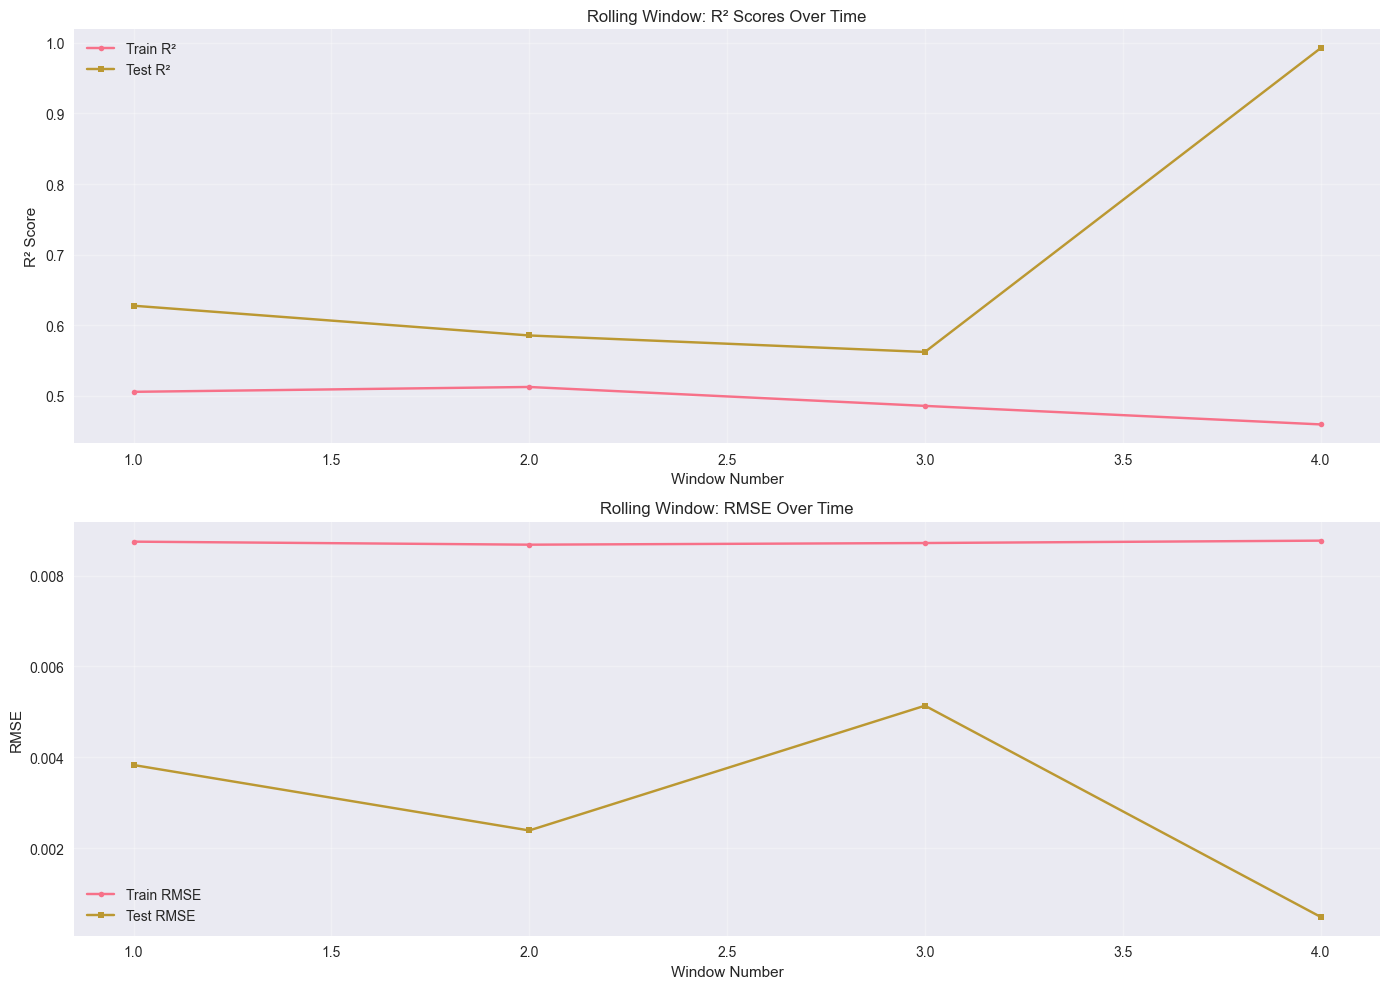

In [42]:
# Plot rolling window performance over time
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# R² scores
axes[0].plot(results_df['window'], results_df['train_r2'], label='Train R²', marker='o', markersize=4)
axes[0].plot(results_df['window'], results_df['test_r2'], label='Test R²', marker='s', markersize=4)
axes[0].set_xlabel('Window Number')
axes[0].set_ylabel('R² Score')
axes[0].set_title('Rolling Window: R² Scores Over Time')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# RMSE
axes[1].plot(results_df['window'], results_df['train_rmse'], label='Train RMSE', marker='o', markersize=4)
axes[1].plot(results_df['window'], results_df['test_rmse'], label='Test RMSE', marker='s', markersize=4)
axes[1].set_xlabel('Window Number')
axes[1].set_ylabel('RMSE')
axes[1].set_title('Rolling Window: RMSE Over Time')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
# Combine all predictions from rolling windows
all_predictions = []
all_actuals = []
all_dates = []

for result in rolling_results:
    all_predictions.extend(result['predictions'])
    all_actuals.extend(result['actuals'])
    all_dates.extend(result['dates'])

# Create combined dataframe
combined_df = pd.DataFrame({
    'Date': pd.to_datetime(all_dates),
    'Actual': all_actuals,
    'Predicted': all_predictions
}).sort_values('Date').reset_index(drop=True)

# Calculate overall metrics
overall_rmse = np.sqrt(mean_squared_error(combined_df['Actual'], combined_df['Predicted']))
overall_mae = mean_absolute_error(combined_df['Actual'], combined_df['Predicted'])
overall_r2 = r2_score(combined_df['Actual'], combined_df['Predicted'])

print("=== Overall Rolling Window Performance ===")
print(f"RMSE: {overall_rmse:.6f}")
print(f"MAE: {overall_mae:.6f}")
print(f"R²: {overall_r2:.4f}")

# Plot combined predictions
plt.figure(figsize=(14, 6))
plt.plot(combined_df['Date'], combined_df['Actual'], label='Actual', alpha=0.7, linewidth=1)
plt.plot(combined_df['Date'], combined_df['Predicted'], label='Predicted', alpha=0.7, linewidth=1)
plt.xlabel('Date')
plt.ylabel('Return')
plt.title(f'Rolling Window: Combined Predictions vs Actual (R² = {overall_r2:.4f})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Comparison: 80/20 vs Rolling Window


=== Model Comparison ===
         Approach  Test RMSE  Test MAE   Test R²
0     80/20 Split   0.000489  0.002354  0.992669
1  Rolling Window   0.003886  0.002553  0.602497


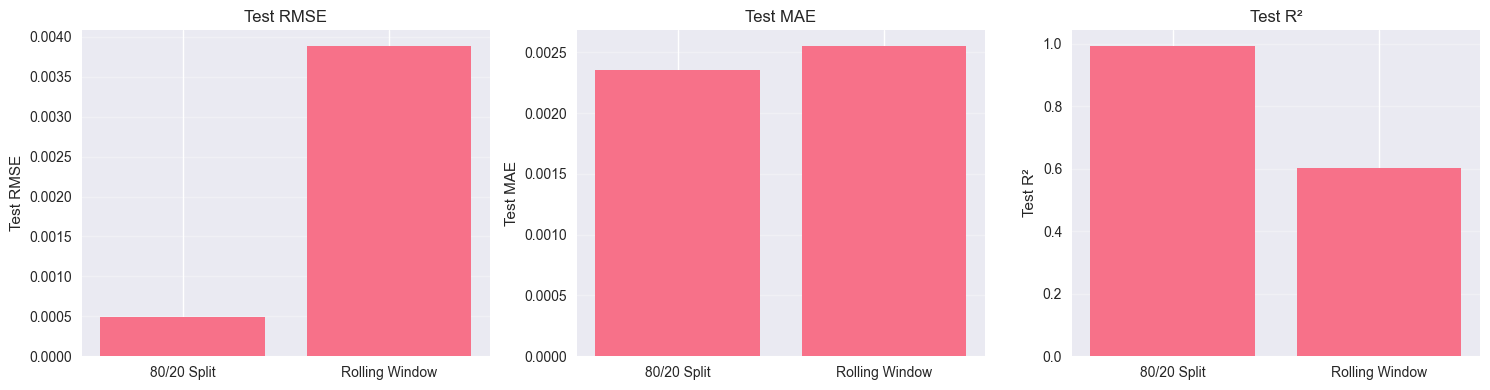

In [ ]:
# Compare approaches
comparison = pd.DataFrame({
    'Approach': ['80/20 Split', 'Rolling Window'],
    'Test RMSE': [test_rmse, overall_rmse],
    'Test MAE': [test_mae, overall_mae],
    'Test R²': [test_r2, overall_r2]
})

print("=== Model Comparison ===")
print(comparison)

# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

metrics = ['Test RMSE', 'Test MAE', 'Test R²']
for i, metric in enumerate(metrics):
    axes[i].bar(comparison['Approach'], comparison[metric])
    axes[i].set_title(metric)
    axes[i].set_ylabel(metric)
    axes[i].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


## Trading Strategy Backtest


In [ ]:
# Trading strategy: Buy at open, sell at close on same day
def backtest_strategy(actual_returns, predicted_returns, threshold=0.0):
    """
    Strategy: 
    - Use Fed probabilities from 00:00 (midnight) on day T
    - Predict intraday return (Open to Close) on day T
    - If predicted return > threshold: Buy at open, sell at close
    - Else: Hold cash (no position)
    """
    signals = (predicted_returns > threshold).astype(int)
    strategy_returns = signals * actual_returns
    
    cumulative_returns = (1 + strategy_returns).cumprod()
    buy_hold_returns = (1 + actual_returns).cumprod()
    
    total_return = cumulative_returns.iloc[-1] - 1
    buy_hold_return = buy_hold_returns.iloc[-1] - 1
    
    # Annualized Sharpe ratio (assuming ~252 trading days)
    sharpe_ratio = strategy_returns.mean() / strategy_returns.std() * np.sqrt(252) if strategy_returns.std() > 0 else 0
    
    # Calculate additional metrics
    num_trades = signals.sum()
    win_rate = (strategy_returns[signals == 1] > 0).mean() if num_trades > 0 else 0
    avg_return_per_trade = strategy_returns[signals == 1].mean() if num_trades > 0 else 0
    
    return {
        'signals': signals,
        'strategy_returns': strategy_returns,
        'cumulative_returns': cumulative_returns,
        'buy_hold_returns': buy_hold_returns,
        'total_return': total_return,
        'buy_hold_return': buy_hold_return,
        'sharpe_ratio': sharpe_ratio,
        'win_rate': win_rate,
        'num_trades': num_trades,
        'avg_return_per_trade': avg_return_per_trade
    }

# Backtest on 80/20 test set
# Make sure we use the correct predictions from 80/20 split
test_returns = pd.Series(y_test.values, index=dates_test.values)
test_preds = pd.Series(y_test_pred_80_20, index=dates_test.values)

strategy_80_20 = backtest_strategy(test_returns, test_preds, threshold=0.0)

print("=== Trading Strategy Performance (80/20 Test Set) ===")
print(f"Strategy: Buy at open, sell at close on same day")
print(f"Strategy Total Return: {strategy_80_20['total_return']*100:.2f}%")
print(f"Buy & Hold Return: {strategy_80_20['buy_hold_return']*100:.2f}%")
print(f"Sharpe Ratio: {strategy_80_20['sharpe_ratio']:.4f}")
print(f"Number of Trades: {strategy_80_20['num_trades']}")
print(f"Win Rate: {strategy_80_20['win_rate']*100:.2f}%")
print(f"Avg Return per Trade: {strategy_80_20['avg_return_per_trade']*100:.4f}%")

# Backtest on rolling window predictions
rolling_returns = pd.Series(combined_df['Actual'].values, index=combined_df['Date'])
rolling_preds = pd.Series(combined_df['Predicted'].values, index=combined_df['Date'])

strategy_rolling = backtest_strategy(rolling_returns, rolling_preds, threshold=0.0)

print("\n=== Trading Strategy Performance (Rolling Window) ===")
print(f"Strategy: Buy at open, sell at close on same day")
print(f"Strategy Total Return: {strategy_rolling['total_return']*100:.2f}%")
print(f"Buy & Hold Return: {strategy_rolling['buy_hold_return']*100:.2f}%")
print(f"Sharpe Ratio: {strategy_rolling['sharpe_ratio']:.4f}")
print(f"Number of Trades: {strategy_rolling['num_trades']}")
print(f"Win Rate: {strategy_rolling['win_rate']*100:.2f}%")
print(f"Avg Return per Trade: {strategy_rolling['avg_return_per_trade']*100:.4f}%")


NameError: name 'y_test_pred_80_20' is not defined

In [ ]:
# Plot cumulative returns
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# 80/20 strategy
test_dates = pd.to_datetime(dates_test.values)
axes[0].plot(test_dates, strategy_80_20['cumulative_returns'], label='Strategy', linewidth=2)
axes[0].plot(test_dates, strategy_80_20['buy_hold_returns'], label='Buy & Hold', linewidth=2, linestyle='--')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Cumulative Return')
axes[0].set_title('80/20 Split: Strategy vs Buy & Hold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Rolling window strategy
axes[1].plot(combined_df['Date'], strategy_rolling['cumulative_returns'], label='Strategy', linewidth=2)
axes[1].plot(combined_df['Date'], strategy_rolling['buy_hold_returns'], label='Buy & Hold', linewidth=2, linestyle='--')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Cumulative Return')
axes[1].set_title('Rolling Window: Strategy vs Buy & Hold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Alternative: Simpler Models for Small Data


In [ ]:
# For small datasets, simpler models often work better
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor

print("=== Trying Simpler Models for Small Dataset ===\n")

# Use selected features
X_train_simple = X_train_selected
X_test_simple = X_test_selected

models = {
    'Ridge Regression': Ridge(alpha=1.0, random_state=42),
    'Lasso Regression': Lasso(alpha=0.1, random_state=42, max_iter=2000),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42, max_iter=2000),
    'Random Forest (small)': RandomForestRegressor(n_estimators=50, max_depth=3, random_state=42, n_jobs=-1)
}

results = []

for name, model in models.items():
    model.fit(X_train_simple, y_train)
    y_train_pred = model.predict(X_train_simple)
    y_test_pred = model.predict(X_test_simple)
    
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    results.append({
        'Model': name,
        'Train R²': train_r2,
        'Test R²': test_r2,
        'Test RMSE': test_rmse
    })
    
    print(f"{name}:")
    print(f"  Train R²: {train_r2:.4f}")
    print(f"  Test R²: {test_r2:.4f}")
    print(f"  Test RMSE: {test_rmse:.6f}\n")

results_df = pd.DataFrame(results)
print("=== Model Comparison ===")
print(results_df.to_string(index=False))

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(results_df['Model'], results_df['Test R²'])
axes[0].set_ylabel('Test R²')
axes[0].set_title('Test R² by Model')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].axhline(y=0, color='r', linestyle='--', alpha=0.5, label='Baseline (mean)')
axes[0].legend()

axes[1].bar(results_df['Model'], results_df['Test RMSE'])
axes[1].set_ylabel('Test RMSE')
axes[1].set_title('Test RMSE by Model')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


=== Trying Simpler Models for Small Dataset ===



NameError: name 'X_train_selected' is not defined